In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio

import matplotlib.pyplot as plt

from rasterio import features, windows

from geographiclib.geodesic import Geodesic
from shapely.geometry import Polygon

import tqdm.notebook as tqdm

from torch.utils.data import Sampler, Dataset
from typing import Iterator

In [2]:
def get_square_area(longitude: float, latitude: float,
                    square_length: float = 60., geod: Geodesic = None):
    """
    Args:
        lat: Latitude
        lon: Longtitude
        square_length: Measured in meters.
        geod: (Geodesic)
    """
    if geod is None:
        #Define the ellipsoid
        geod = Geodesic.WGS84
        
    diag_len = np.sqrt(2*(square_length / 2.)**2)
    lr_point = geod.Direct(latitude, longitude, 135, diag_len)
    ll_point = geod.Direct(latitude, longitude, -135, diag_len)
    ul_point = geod.Direct(latitude, longitude, -45, diag_len)
    ur_point = geod.Direct(latitude, longitude, 45, diag_len)
    return [
        # lr = lower right
        [lr_point['lon2'], lr_point['lat2']],
        # ll = lower left
        [ll_point['lon2'], ll_point['lat2']],
        # ul = upper left
        [ul_point['lon2'], ul_point['lat2']],
        # ur = upper right
        [ur_point['lon2'], ur_point['lat2']]
    ]

In [3]:
def get_bounds():
    
    rwanda_df, uganda_df = get_dfs()

    lat_name = "GPS (Latitude)"
    lon_name = "GPS (Longitude)"

    bounds_dict = {c: {} for c in ["rwanda", "uganda"]}

    exclude_ids = ["1023076"]
    min_lat, max_lat = float("inf"), - float("inf")
    min_lon, max_lon = float("inf"), - float("inf")
    
    for i, row in uganda_df.iterrows():
        if row["Opportunity Unique Identifier"] in exclude_ids:
            continue
        lat = row[lat_name]
        lon = row[lon_name]
        min_lat = min(min_lat, lat)
        max_lat = max(max_lat, lat)
        min_lon = min(min_lon, lon)
        max_lon = max(max_lon, lon)

    min_lat -= 30 / 3600
    max_lat += 30 / 3600
    min_lon -= 30 / 3600
    max_lon += 30 / 3600

    bounds_dict["uganda"] = {
        "left": min_lon,
        "bottom": min_lat,
        "right": max_lon,
        "top": max_lat
    }

    rwanda_fp = "../data/country_masks/rwanda_mask_1-3600.tiff"
    rwanda = rasterio.open(rwanda_fp)

    bounds_dict["rwanda"] = {
        "left": rwanda.bounds.left,
        "bottom": rwanda.bounds.bottom,
        "right": rwanda.bounds.right,
        "top": rwanda.bounds.top
    }
    return bounds_dict

In [4]:
def get_dfs():
    rwanda_df = pd.read_csv(
        "../data/ground_truth/"
        "Rwanda training data_AllSitesMinusVehicleBridges_21.11.05.csv")
    rwanda_df.dropna(inplace=True)
    print("Number of Rwanda data points: {}".format(len(rwanda_df)))

    uganda_df = pd.read_csv(
        "../data/ground_truth/Uganda_TrainingData_3districts_ADSK.csv")
    uganda_df.dropna(inplace=True)
    print("Number of Uganda data points: {}".format(len(uganda_df)))

    return rwanda_df, uganda_df

In [5]:
def get_val_range():
    val_range = (
        bounds_dict["rwanda"]["left"] + (
            bounds_dict["rwanda"]["right"] - bounds_dict["rwanda"]["left"]
        ) / 10 * 5,
        bounds_dict["rwanda"]["left"] + (
            bounds_dict["rwanda"]["right"] - bounds_dict["rwanda"]["left"]
        ) / 10 * 6
    )
    return val_range

# Create positive areas

In [6]:
rwanda_df, uganda_df = get_dfs()
thres = 50

lat_name = "GPS (Latitude)"
lon_name = "GPS (Longitude)"

for tile_size in [300, 600, 1200]:
    pos_area_size = (tile_size - thres) * 4
    
    recid_name = "Record ID"
    rwanda_polygons = []
    for i, row in rwanda_df.iterrows():
        lat = row[lat_name]
        lon = row[lon_name]
        rec_id = row[recid_name]
        squared_area = get_square_area(lon, lat, square_length=pos_area_size)
        polygon = Polygon(squared_area)
        rwanda_polygons.append(polygon)

    recid_name = "Opportunity Unique Identifier"
    uganda_polygons = []
    for i, row in uganda_df.iterrows():
        lat = row[lat_name]
        lon = row[lon_name]
        rec_id = row[recid_name]
        squared_area = get_square_area(lon, lat, square_length=pos_area_size)
        polygon = Polygon(squared_area)
        uganda_polygons.append(polygon)
    
    gpd.GeoSeries(rwanda_polygons, crs="EPSG:4326").to_file(
        "../data/ground_truth/rwanda_train_{}.geojson".format(tile_size))
    gpd.GeoSeries(uganda_polygons, crs="EPSG:4326").to_file(
        "../data/ground_truth/uganda_train_{}.geojson".format(tile_size))

Number of Rwanda data points: 1429
Number of Uganda data points: 251


# Create negative coordinates

In [101]:
bounds_dict = get_bounds()
print(json.dumps(bounds_dict, indent=4))

step_size = 10 / 3600

for tile_size in [300, 600, 1200]:
    for country, bounds in bounds_dict.items():
        print("Country: {}, tile size: {}".format(country, tile_size))
        if country == "rwanda":
            gt_raster = rasterio.open(
                "../data/ground_truth/rwanda_train_{}_1-3600.tiff".format(
                    tile_size))
            country_raster = rasterio.open(
                "../data/country_masks/rwanda_mask_1-3600.tiff")
        elif country == "uganda":
            gt_raster = rasterio.open(
                "../data/ground_truth/uganda_train_{}_1-3600.tiff".format(
                    tile_size))
            country_raster = rasterio.open(
                "../data/country_masks/uganda_mask_1-3600.tiff")
        else:
            raise NotImplementedError
        
        lon_range = np.linspace(
            bounds["left"],
            bounds["right"],
            num=int((bounds["right"] - bounds["left"]) / step_size)
        )
        lat_range = np.linspace(
            bounds["bottom"],
            bounds["top"],
            num=int(np.abs(bounds["bottom"] - bounds["top"]) / step_size)
        )
        num_gt_pos_area = 0
        num_coords = 0
        num_valid_coords = 0
        num_too_small_area = 0
        num_out_of_bounds = 0

        pbar = tqdm.tqdm(
            range(lat_range.shape[0]), total=lat_range.shape[0],
            desc="Iterate through range:")
        coords_data = [["left", "bottom", "right", "top"]]
        for i in pbar:
            for j in range(lon_range.shape[0]):
                # latitude, longitude
                lat = lat_range[i]
                lon = lon_range[j]
                # coordinates of area with size tile_size
                area_coords = get_square_area(lon, lat, square_length=tile_size)
                # get left = lat, bottom = lon, right = lat, top = lon
                left = min([ac[0] for ac in area_coords])
                bottom = min([ac[1] for ac in area_coords])
                right = max([ac[0] for ac in area_coords])
                top = max([ac[1] for ac in area_coords])
                
                if (left < bounds["left"] or right > bounds["right"] or
                        bottom < bounds["bottom"] or top > bounds["top"]):
                    num_out_of_bounds += 1
                    continue                    
                window_gt = windows.from_bounds(
                    left, bottom, right, top, gt_raster.transform)
                window_co = windows.from_bounds(
                    left, bottom, right, top, country_raster.transform)
                # country mask
                gt_mask = gt_raster.read(1, window=window_gt)
                co_mask = country_raster.read(1, window=window_co)
                num_coords += 1
                if gt_mask.sum() > 0:
                    num_gt_pos_area += 1
                    continue
                if np.prod(np.array(co_mask.shape)) == 0:
                    raise Exception("Array == 0.")
                if co_mask.sum() / np.prod(np.array(co_mask.shape)) < 0.75:
                    num_too_small_area += 1
                    continue
                num_valid_coords += 1
                coords_data.append([left, bottom, right, top])
                
            pbar.set_description(
                "[{}] total: {} pos: {} small: {} ood: {} neg: {}".format(
                    i, num_coords, num_gt_pos_area, num_too_small_area, 
                    num_out_of_bounds, num_valid_coords))
        target_fp = "../data/ground_truth/{}_{}_negatives.csv".format(
            country, tile_size)
        pd.DataFrame(coords_data[1:], columns=coords_data[0]).to_csv(
            target_fp, index=False)
        

Number of Rwanda data points: 1429
Number of Uganda data points: 251
{
    "rwanda": {
        "left": 28.854442596,
        "bottom": -2.8255556621111113,
        "right": 30.893331484888886,
        "top": -1.054444551
    },
    "uganda": {
        "left": 29.727706666666666,
        "bottom": -0.29569133333333336,
        "right": 30.608246333333334,
        "top": 0.8944093333333333
    }
}
Country: rwanda, tile size: 300


Iterate through range::   0%|          | 0/637 [00:00<?, ?it/s]

Country: uganda, tile size: 300


Iterate through range::   0%|          | 0/428 [00:00<?, ?it/s]

Country: rwanda, tile size: 600


Iterate through range::   0%|          | 0/637 [00:00<?, ?it/s]

Country: uganda, tile size: 600


Iterate through range::   0%|          | 0/428 [00:00<?, ?it/s]

Country: rwanda, tile size: 1200


Iterate through range::   0%|          | 0/637 [00:00<?, ?it/s]

Country: uganda, tile size: 1200


Iterate through range::   0%|          | 0/428 [00:00<?, ?it/s]

# Processing Training data

## Merging Uganda and Rwanda data into one DF

In [14]:
rwanda_df, uganda_df = get_dfs()
bounds_dict = get_bounds()

lat_name = "GPS (Latitude)"
lon_name = "GPS (Longitude)"

# add country name
rwanda_df["Country"] = "Rwanda"
uganda_df["Country"] = "Uganda"
# rename `Record ID` to `Opportunity ID`
rwanda_df.rename(columns={"Record ID": "Opportunity ID"}, inplace=True)
# exclude 0063Z00000ixAgR due to wrong coordinates
uganda_df.drop(
    uganda_df[uganda_df["Opportunity ID"] == "0063Z00000ixAgR"].index[0],
    axis=0, inplace=True)
# adding country shortcut to be (for sure) unique
rwanda_df["Opportunity ID"] = "rw-" + rwanda_df["Opportunity ID"]
uganda_df["Opportunity ID"] = "ug-" + uganda_df["Opportunity ID"]
# drop tables that we don't need
uganda_df.drop("Opportunity Unique Identifier", axis=1, inplace=True)
rwanda_df.drop("Site Name", axis=1, inplace=True)
# concat
rw_ug_df = pd.concat([rwanda_df, uganda_df])
# reset index
rw_ug_df.reset_index(drop=True, inplace=True)
rw_ug_df["Split"] = ""
rw_ug_df = rw_ug_df.astype({
    "Opportunity ID": str,
    "GPS (Latitude)": float,
    "GPS (Longitude)": float,
    "Country": str,
    "Split": str
})


rw_ug_df

Number of Rwanda data points: 1429
Number of Uganda data points: 251
Number of Rwanda data points: 1429
Number of Uganda data points: 251


,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split
0,rw-006f100000a86EH,-2.168670,30.262610,Rwanda,
1,rw-006f100000dhpDZ,-2.188740,29.690270,Rwanda,
2,rw-006f100000ZQRps,-1.555918,30.211844,Rwanda,
3,rw-006f100000ZQRkP,-1.848167,30.097000,Rwanda,
4,rw-006f100000ZQRpz,-1.813833,30.098779,Rwanda,
...,...,...,...,...,...
1674,ug-0063Z00000oLjgc,0.175244,29.964349,Uganda,
1675,ug-0063Z00000oLjgh,0.165684,29.964487,Uganda,
1676,ug-0063Z00000oLjgm,0.155498,29.965507,Uganda,
1677,ug-0063Z00000oLjgr,0.108615,29.736040,Uganda,


## Validating training data

In [17]:
# left, right: Longitude
# bottom, top: Latitude

In [95]:
rw_ug_df[(rw_ug_df.Country == "Rwanda") & (
    (rw_ug_df.left < bounds_dict["rwanda"]["left"]) |
    (rw_ug_df.right < bounds_dict["rwanda"]["right"]) | 
    (rw_ug_df.bottom < bounds_dict["rwanda"]["bottom"]) | 
    (rw_ug_df.top < bounds_dict["rwanda"]["top"])
)]

,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split,left,right,bottom,top,pos_neg


In [96]:
rw_ug_df[(rw_ug_df.Country == "Uganda") & (
    (rw_ug_df.left < bounds_dict["uganda"]["left"]) |
    (rw_ug_df.right < bounds_dict["uganda"]["right"]) | 
    (rw_ug_df.bottom < bounds_dict["uganda"]["bottom"]) | 
    (rw_ug_df.top < bounds_dict["uganda"]["top"])
)]

,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split,left,right,bottom,top,pos_neg


In [18]:
print("Threshold: {}".format(bounds_dict["rwanda"]["bottom"]))
rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lat_name] < bounds_dict["rwanda"]["bottom"])
]

Threshold: -2.8255556621111113


,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split


In [19]:
print("Threshold: {}".format(bounds_dict["rwanda"]["top"]))
rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lat_name] > bounds_dict["rwanda"]["top"])
]

Threshold: -1.054444551


,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split
812,rw-006f100000a86FN,2.472400,29.500000,Rwanda,
857,rw-006f100000d7JDC,2.442831,29.499347,Rwanda,
895,rw-006f100000a86GS,2.713945,29.594535,Rwanda,


In [20]:
# drop
indeces = rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lat_name] > bounds_dict["rwanda"]["top"])
].index
rw_ug_df.drop(indeces, axis=0, inplace=True)
rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lat_name] > bounds_dict["rwanda"]["top"])
]

,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split


In [21]:
print("Threshold: {}".format(bounds_dict["rwanda"]["left"]))
rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lon_name] < bounds_dict["rwanda"]["left"])
]

Threshold: 28.854442596


,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split
993,rw-006f100000d88A3,-2.19348,-29.49645,Rwanda,
1160,rw-006f100000d1hU7,-2.58127,28.15265,Rwanda,


In [22]:
# drop 
indeces = rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lon_name] < bounds_dict["rwanda"]["left"])
].index
rw_ug_df.drop(indeces, axis=0, inplace=True)
rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (
        rw_ug_df[lon_name] < bounds_dict["rwanda"]["left"])
]

,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split


In [23]:
print("Threshold: {}".format(bounds_dict["rwanda"]["right"]))
rw_ug_df[
    (rw_ug_df["Country"] == "Rwanda") & (rw_ug_df[lon_name] > bounds_dict["rwanda"]["right"])
]

Threshold: 30.893331484888886


,Opportunity ID,GPS (Latitude),GPS (Longitude),Country,Split


## Split positives into train/val/test

In [24]:
rw_ug_df.loc[rw_ug_df.Country == "Uganda", "Split"] = "test"

In [25]:
val_range = get_val_range()

In [26]:
# left, right: Longitude
# bottom, top: Latitude
rw_ug_df.loc[(rw_ug_df.Country == "Rwanda") & (
    rw_ug_df[lon_name] < val_range[0]), "Split"] = "train"
rw_ug_df.loc[(rw_ug_df.Country == "Rwanda") & (
    val_range[0] <= rw_ug_df[lon_name]) & (
        rw_ug_df[lon_name] < val_range[1]), "Split"] = "val"
rw_ug_df.loc[(rw_ug_df.Country == "Rwanda") & (
    val_range[1] <= rw_ug_df[lon_name]), "Split"] = "train"

In [27]:
print("Train: {} Val: {} Test: {}".format(
    len(rw_ug_df[rw_ug_df.Split == "train"]),
    len(rw_ug_df[rw_ug_df.Split == "val"]),
    len(rw_ug_df[rw_ug_df.Split == "test"])
))

Train: 1243 Val: 181 Test: 250


In [28]:
rw_ug_df.to_csv(
    "../data/ground_truth/training_data_pos.csv", index=False)

## Split negatives into train/val/test

In [102]:
bounds_dict = get_bounds()
print(json.dumps(bounds_dict, indent=4))

Number of Rwanda data points: 1429
Number of Uganda data points: 251
{
    "rwanda": {
        "left": 28.854442596,
        "bottom": -2.8255556621111113,
        "right": 30.893331484888886,
        "top": -1.054444551
    },
    "uganda": {
        "left": 29.727706666666666,
        "bottom": -0.29569133333333336,
        "right": 30.608246333333334,
        "top": 0.8944093333333333
    }
}


In [103]:
dtype = {"left": float, "right": float, "bottom": float, "top": float}
val_range = get_val_range()

for tile_size in [300, 600, 1200]:
    rwanda_df = pd.read_csv(
        "../data/ground_truth/{}_{}_negatives.csv".format("rwanda", tile_size),
        dtype=dtype)
    uganda_df = pd.read_csv(
        "../data/ground_truth/{}_{}_negatives.csv".format("uganda", tile_size),
        dtype=dtype)

    assert rwanda_df.left.max() <= bounds_dict["rwanda"]["right"]
    assert rwanda_df.left.min() >= bounds_dict["rwanda"]["left"]
    assert rwanda_df.right.max() <= bounds_dict["rwanda"]["right"]
    assert rwanda_df.right.min() >= bounds_dict["rwanda"]["left"]

    assert rwanda_df.bottom.max() <= bounds_dict["rwanda"]["top"]
    assert rwanda_df.bottom.min() >= bounds_dict["rwanda"]["bottom"]
    assert rwanda_df.top.max() <= bounds_dict["rwanda"]["top"]
    assert rwanda_df.top.min() >= bounds_dict["rwanda"]["bottom"]

    assert uganda_df.left.max() <= bounds_dict["uganda"]["right"]
    assert uganda_df.left.min() >= bounds_dict["uganda"]["left"]
    assert uganda_df.right.max() <= bounds_dict["uganda"]["right"]
    assert uganda_df.right.min() >= bounds_dict["uganda"]["left"]

    assert uganda_df.bottom.max() <= bounds_dict["uganda"]["top"]
    assert uganda_df.bottom.min() >= bounds_dict["uganda"]["bottom"]
    assert uganda_df.top.max() <= bounds_dict["uganda"]["top"]
    assert uganda_df.top.min() >= bounds_dict["uganda"]["bottom"]

    rwanda_df["Country"] = "Rwanda"
    uganda_df["Country"] = "Uganda"
    neg_df = pd.concat([rwanda_df, uganda_df])
    neg_df.reset_index(drop=True, inplace=True)
    neg_df["Split"] = ""
    
    neg_df.loc[neg_df.Country == "Uganda", "Split"] = "test"

    neg_df.loc[(neg_df.Country == "Rwanda") & (
        neg_df.right < val_range[0]), "Split"] = "train"
    neg_df.loc[(neg_df.Country == "Rwanda") & (
        val_range[0] <= neg_df.left) & (
            neg_df.right < val_range[1]), "Split"] = "val"
    neg_df.loc[(neg_df.Country == "Rwanda") & (
        val_range[1] <= neg_df.left), "Split"] = "train"

    print("Train: {} Val: {} Test: {}".format(
        len(neg_df[neg_df.Split == "train"]),
        len(neg_df[neg_df.Split == "val"]),
        len(neg_df[neg_df.Split == "test"])
    ))
    
    neg_df.to_csv(
        "../data/ground_truth/training_data_neg_{}.csv".format(tile_size),
        index=False)

Train: 219044 Val: 23235 Test: 112870
Train: 175782 Val: 17030 Test: 104934
Train: 103489 Val: 6067 Test: 87770


## Merge pos and negatives

In [75]:
for tile_size in [300, 600, 1200]:
    rw_ug_df = pd.read_csv(
        "../data/ground_truth/training_data_pos.csv")
    neg_df = pd.read_csv(
        "../data/ground_truth/training_data_neg_{}.csv".format(tile_size))
    rw_ug_df["left"] = None
    rw_ug_df["right"] = None
    rw_ug_df["bottom"] = None
    rw_ug_df["top"] = None
    rw_ug_df["pos_neg"] = "pos"

    neg_df["GPS (Latitude)"] = None
    neg_df["GPS (Longitude)"] = None
    neg_df["pos_neg"] = "neg"
    
    df = pd.concat([rw_ug_df, neg_df])
    df.reset_index(drop=True, inplace=True)
    df.to_csv(
        "../data/ground_truth/training_data_{}.csv".format(tile_size),
        index=False)

## Calculate means and stds of each datasets

In [95]:
MEAN_STD = {
    "osm_imgs_mean": [228.9456722483024, 232.141690104963, 220.64054439337642],
    "osm_imgs_std": [25.0031179831636, 14.698174522550094, 25.432728714568253],
    "pop_mean": [12.024757385253906],
    "pop_std": [15.575993537902832],
    "slope_mean": [],
    "slope_std": [],
    "elevation_mean": [],
    "elevation_std": []
}

### Elevation

Elevation

Mean: 220.90135321668626 Std: 9.3889976864778


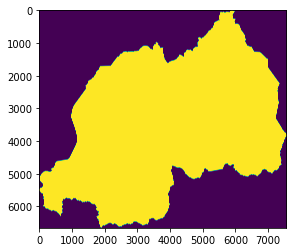

In [96]:
src_rw = rasterio.open("../data/slope_elevation/elevation_rwanda.tif")
src_ug = rasterio.open("../data/slope_elevation/elevation_uganda.tif")

assert np.unique(src_rw.read(1)).tolist() == [0, 255]
assert np.unique(src_ug.read(1)).tolist() == [0, 255]

assert np.all(src_rw.read(2) == src_rw.read(3))
assert np.all(src_ug.read(2) == src_ug.read(3))

plt.imshow(src_rw.read(1))

valid_elevation = np.concatenate((
    src_rw.read(2).flatten()[src_rw.read(1).flatten() == 255],
    src_ug.read(2).flatten()[src_ug.read(1).flatten() == 255]))

mean_elevation = np.mean(valid_elevation)
std_elevation = np.std(valid_elevation)
print("Elevation\n")
print("Mean: {} Std: {}".format(mean_elevation, std_elevation))

Slope

Mean: 241.3060780142587 Std: 17.980819167026993


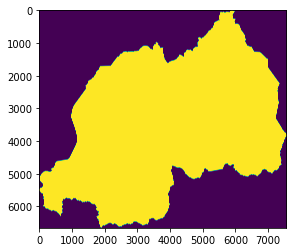

In [97]:
src_rw = rasterio.open("../data/slope_elevation/slope_rwanda.tif")
src_ug = rasterio.open("../data/slope_elevation/slope_uganda.tif")

assert np.unique(src_rw.read(1)).tolist() == [0, 255]
assert np.unique(src_ug.read(1)).tolist() == [0, 255]

assert np.all(src_rw.read(2) == src_rw.read(3))
assert np.all(src_ug.read(2) == src_ug.read(3))

plt.imshow(src_rw.read(1))

valid_slope = np.concatenate((
    src_rw.read(2).flatten()[src_rw.read(1).flatten() == 255],
    src_ug.read(2).flatten()[src_ug.read(1).flatten() == 255]))

mean_slope = np.mean(valid_slope)
std_slope = np.std(valid_slope)

print("Slope\n")
print("Mean: {} Std: {}".format(mean_slope, std_slope))

### Population

In [98]:
src_ug = rasterio.open(
    "../data/population/Uganda_population_data_2020_UNadj_constrained.tif")
src_rw = rasterio.open(
    "../data/population/Rwanda_population_data_2020_UNadj_constrained.tif")


In [99]:
pop_data = np.concatenate((
    src_ug.read(1)[src_ug.read(1) >= 0].flatten(),
    src_rw.read(1)[src_rw.read(1) >= 0].flatten()))
mean_pop = np.mean(pop_data)
std_pop = np.std(pop_data)
print("Population")
print("Mean: {} Std: {}".format(mean_pop, std_pop))

Population
Mean: 12.024757385253906 Std: 15.575993537902832


### OSM images

In [100]:
src_rw = rasterio.open("../data/osm/imgs/rwanda_osm_nolab_1-50000.tiff")
src_ug = rasterio.open("../data/osm/imgs/uganda_train_osm_nolab_1-50000.tiff")

In [101]:
c1 = np.concatenate((src_rw.read(1).flatten(), src_ug.read(1).flatten()))
c2 = np.concatenate((src_rw.read(2).flatten(), src_ug.read(2).flatten()))
c3 = np.concatenate((src_rw.read(3).flatten(), src_ug.read(3).flatten()))
mean_imgs = [np.mean(c1), np.mean(c2), np.mean(c3)]
std_imgs = [np.std(c1), np.std(c2), np.std(c3)]
print("Mean: {} Std: {}".format(mean_imgs, std_imgs))

Mean: [228.9456722483024, 232.141690104963, 220.64054439337642] Std: [25.0031179831636, 14.698174522550094, 25.432728714568253]


# Pytorch

## Dataset loader

In [130]:
TRAIN_METADATA = {
    "Rwanda": {
        "population": {
            "fp": ("../data/population/"
                   "Rwanda_population_data_2020_UNadj_constrained.tif"),
            "raster_channels": [1]
        },
        "osm_imgs": {
            "fp": "../data/osm/imgs/rwanda_osm_nolab_1-50000_4326.tiff",
            "raster_channels": [1, 2, 3]
        },
        "elevation": {
            "fp": "../data/slope_elevation/elevation_rwanda.tif",
            "raster_channels": [2]
        },
        "slope": {
            "fp": "../data/slope_elevation/slope_rwanda.tif",
            "raster_channels": [2]
        }
    },
    "Uganda": {
        "population": {
            "fp": ("../data/population/"
                   "Uganda_population_data_2020_UNadj_constrained.tif"),
            "raster_channels": [1]
        },
        "osm_imgs": {
            "fp": "../data/osm/imgs/uganda_train_osm_nolab_1-50000_4326.tiff",
            "raster_channels": [1, 2, 3]
        },
        "elevation": {
            "fp": "../data/slope_elevation/elevation_uganda.tif",
            "raster_channels": [2]
        },
        "slope": {
            "fp": "../data/slope_elevation/slope_uganda.tif",
            "raster_channels": [2]
        }
    },
}

OUTPUT_SIZE = {300: (12, 12), 600: (24, 24), 1200: (48, 48)}
DATA_ORDER = ["population", "osm_imgs", "elevation", "slope"]

TRAINING_DATA = {
    300: "../data/ground_truth/training_data_300.csv",
    600: "../data/ground_truth/training_data_600.csv",
    1200: "../data/ground_truth/training_data_1200.csv"
}
DTYPE = {
    "Opportunity ID": str,
    "GPS (Latitude)": float, 
    "GPS (Longitude)": float, 
    "Country": str,
    "Split": str, 
    "left": float, 
    "right": float,
    "bottom": float, 
    "top": float,
    "pos_neg": str
}

In [134]:
class BridgeDataset(Dataset):
    def __init__(self, tile_size=300, use_rnd_pos=False, transform=False):
        assert tile_size in [300, 600, 1200], "Tile size not known"
        
        self.tile_size = tile_size
        self.training_data = pd.read_csv(
            TRAINING_DATA[tile_size],
            dtype=DTYPE
        )
        self.data_rasters = {}
        for country, data_modalities in TRAIN_METADATA.items():
            if country not in self.data_rasters:
                self.data_rasters[country] = {}
            for data_type, data in data_modalities.items():
                self.data_rasters[country][data_type] = rasterio.open(
                    data["fp"])
        
        self.geod = Geodesic.WGS84
        self.use_rnd_pos = use_rnd_pos
        self.transform = transform
    
    def shift_coords(self, lon, lat):
        lat_shift, lon_shift = np.clip(
            np.random.normal(
                loc=0.0, scale=(self.tile_size - 50) / 4, size=2
            ),
            - (self.tile_size - 50) / 2, 
            (self.tile_size - 50) / 2
        ).tolist()
        if lat_shift < 0:
            lat_shift_degree = 180
        else:
            lat_shift_degree = 0
        if lon_shift < 0:
            lon_shift_degree = 90
        else:
            lon_shift_degree = -90
        lat_shifted = self.geod.Direct(lat, lon, lat_shift_degree, lat_shift)
        new_lat, new_lon = lat_shifted["lat2"], lat_shifted["lon2"]
        lon_shifted = self.geod.Direct(
            new_lat, new_lon, lon_shift_degree, lat_shift)
        new_lat, new_lon = lon_shifted["lat2"], lon_shifted["lon2"]
        return new_lon, new_lat

    def __getitem__(self, idx):
        # get dataset entry
        entry = self.training_data.iloc[idx]
        country = entry.Country
        # positives 
        if entry.pos_neg == "pos":
            label = 1
            lon, lat = entry["GPS (Longitude)"], entry["GPS (Latitude)"]
            if self.use_rnd_pos:
                lon, lat = self.shift_coords(lon, lat)
            # coordinates of area with size tile_size
            area_coords = get_square_area(
                lon, lat, square_length=self.tile_size)
            # get left = lat, bottom = lon, right = lat, top = lon
            left = min([ac[0] for ac in area_coords])
            bottom = min([ac[1] for ac in area_coords])
            right = max([ac[0] for ac in area_coords])
            top = max([ac[1] for ac in area_coords])
        elif entry.pos_neg == "neg":
            label = 0
            left = entry.left
            right = entry.right
            bottom = entry.bottom
            top = entry.top
        else:
            raise NotImplementedError
        imgs = []
        for data_name in DATA_ORDER:
            raster = self.data_rasters[country][data_name]
            window = windows.from_bounds(
                left, bottom, right, top, raster.transform)
            for c in TRAIN_METADATA[country][data_name]["raster_channels"]:
                r = raster.read(
                    c, window=window, out_shape=OUTPUT_SIZE[self.tile_size])
                imgs.append(np.expand_dims(r, -1))
                    
        return np.abs(np.concatenate(imgs, -1))

    def __len__(self):
        return len(self.training_data)

In [144]:
bds = BridgeDataset(1200)

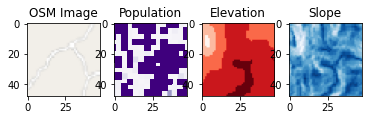

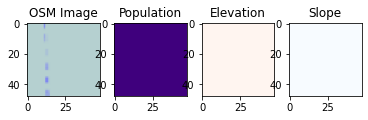

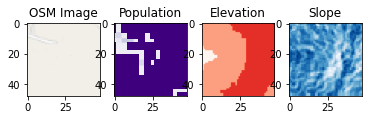

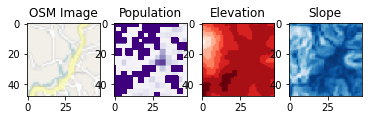

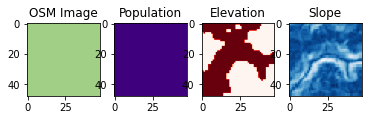

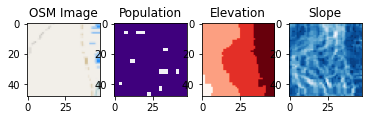

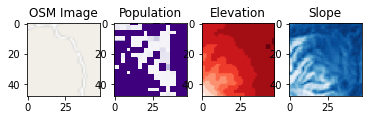

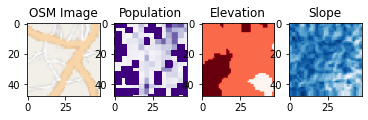

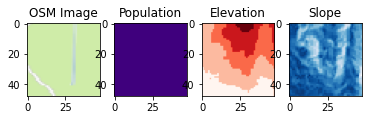

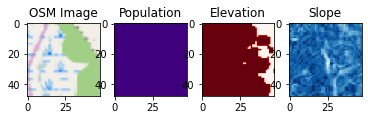

In [145]:
for _ in range(10):
    i = np.random.choice(len(bds))
    imgs = bds[i]
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(imgs[:, :, 1:4].astype(int))
    axes[0].set_title("OSM Image")
    axes[1].imshow(
        imgs[:, :, 0:1].astype(int), vmin=0, vmax=100, cmap="Purples")
    axes[1].set_title("Population")
    axes[2].imshow(
        imgs[:, :, 4:5].astype(int), cmap="Reds")
    axes[2].set_title("Elevation")
    axes[3].imshow(
        imgs[:, :, 5:].astype(int), cmap="Blues")
    axes[3].set_title("Slope")

## Sampler

In [140]:
class BridgeLocationSampler(Sampler):
    def __init__(self, tile_size=300) -> None:
        
    def num_samples(self) -> int:
        return
    def __iter__(self) -> Iterator[int]:
        yield from iter(rand_tensor.tolist())